In [27]:
# -*- coding: <encoding name> -*-
"""Create parameters.py and load it"""
# Directory for .inp file:
#path = 'INP file examples//chemkin_AR_HE_1_reac.inp'
#path = 'INP fil examples//notused_reactions_commented_chemkin_AR_HE.inp'
#path = 'INP file examples//chem_Otomo2018.inp'
path = 'INP file examples//chem_Otomo2018_without_O_reactions_FIXED_by_Cantera.inp'
#path = 'INP file examples//chem_Otomo2018_without_O_reactions_FIXED_by_Cantera.inp'
#path = 'INP file examples//chem_Otomo2018_without_O_just_not_pressure_dependent.inp'
#path = 'INP file examples//chem_Otomo2018_one_Lindemann_reaction.inp'
#path = 'INP file examples//chem_Otomo2018_one_Troe_reaction.inp'
#path = 'INP file examples//chem_Otomo2018_one_PLOG_reaction.inp'
#path = 'INP file examples//chem_Otomo2018_without_O_one_not_pressure_dependent_reaction.inp'
#path = 'INP file examples//chem_Otomo2018_without_O_one_fictive_normal_reaction.inp'
#path = 'INP file examples//chemkin_AR_HE.inp'
#path = 'INP file examples//chem_Otomo2018_1reak.inp'
#path = 'INP file examples//chem_Otomo2018_FIXED_by_Cantera.inp'
#path = 'INP file examples//chem_KAUST2023_N2_carbonfree_FIXED_by_Cantera.inp'
#path = 'INP file examples//chem_KAUST2023_N2_carbonfree.inp'

# import libraries:
import importlib   # For reloading your own files
import numpy as np
# my own files:
import inp_data_extractor as inp   # numeric constants and coefficents
importlib.reload(inp)   # reload changes you made
inp.extract(path)

import parameters as par   # numeric constants and coefficents
importlib.reload(par)   # reload changes you made
print(par.model)

path=INP file examples//chem_Otomo2018_without_O_reactions_FIXED_by_Cantera.inp
Note, lambda value for specie 'NO' is not in data.py: 0.0 is used
Note, lambda value for specie 'H' is not in data.py: 0.0 is used
Note, lambda value for specie 'O' is not in data.py: 0.0 is used
Note, lambda value for specie 'OH' is not in data.py: 0.0 is used
Note, lambda value for specie 'HO2' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH2' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N' is not in data.py: 0.0 is used
Note, lambda value for specie 'NNH' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH2OH' is not in data.py: 0.0 is used
Note, lambda value for specie 'H2NO' is not in data.py: 0.0 is used
Note, lambda value for specie 'HNOH' is not in data.py: 0.0 is used
Note, lambda value for specie 'HNO' is not in data.py: 0.0 is used
Note, lambda value for specie 'HON' is not in data.py:

In [28]:
"""Import simulation"""
import numpy as np
import importlib
import full_bubble_model as de
from termcolor import colored
print(colored('A régi solve_ivp van használva!','red'))
importlib.reload(de)

A régi solve_ivp van használva!
model: chem_Otomo2018_without_O_reactions_FIXED_by_Cantera
target specie: NH3
excitation: sin_impulse (control parameters: ['p_A', 'freq', 'n'])
enable heat transfer: True	enable evaporation: False	enable reactions: True	enable dissipated energy: True	enable reaction rate threshold: True	enable_time_evaluation_limit: False


<module 'full_bubble_model' from 'C:\\Users\\mrkf9\\Documents\\KozakAron\\python\\ammonia_onedrive\\Bubble_dyn_sim\\full_bubble_model.py'>

In [29]:
"""Control parameters"""
cpar = de.dotdict(dict(
    ID=0,
    R_E=50.0e-6, # [m] 
    ratio=1.0, # [-]
    P_standard=101325.0, # [Pa]
    P_amb=100000.0*1.0,#2.2e2, #101325.0*2.0, # [Pa]

    alfa_M=0.99, # [-]
    Gamma=1.0, #[-]
    sigma_evap=0.4, #[-]
    T_inf=293.15, # [K]  #293.15,kuka
    surfactant=1.0, # [-]
    gases=[par.index['H2'], par.index['N2']], # indexes of species in initial bubble
    fractions=[0.75 ,1.0-0.75], # molar fractions of species in initial bubble
    #gases=[par.index['AR']], # indexes of species in initial bubble
    #fractions=[1.0], # molar fractions of species in initial bubble
    P_v = 2338.339978450019,#2338.1, # [Pa]
    mu_L = 0.001, # [Pa*s]
    rho_L= 998.2, # [kg/m^3]
    freq1=2.65e4,                          # [Hz]
    freq2=1.0e5,                          # [Hz]
    p_A1=-1.2e5,                            # [Pa]
    p_A2=0.0e5,                            # [Pa]
    theta_phase=0.1,                      # [rad]
    p_A=-1.2e5,
    freq=20000.0,
    n=1.0,
    c_L=1483.0,                            # [m/s]
    thermodynamicalcase = 2 #0='NonIsothermal-ConstantVolume', 1='Isothermal-ConstantVolume', 2='KellerMiksis
                             #
))

succecfully solved with LSODA solver


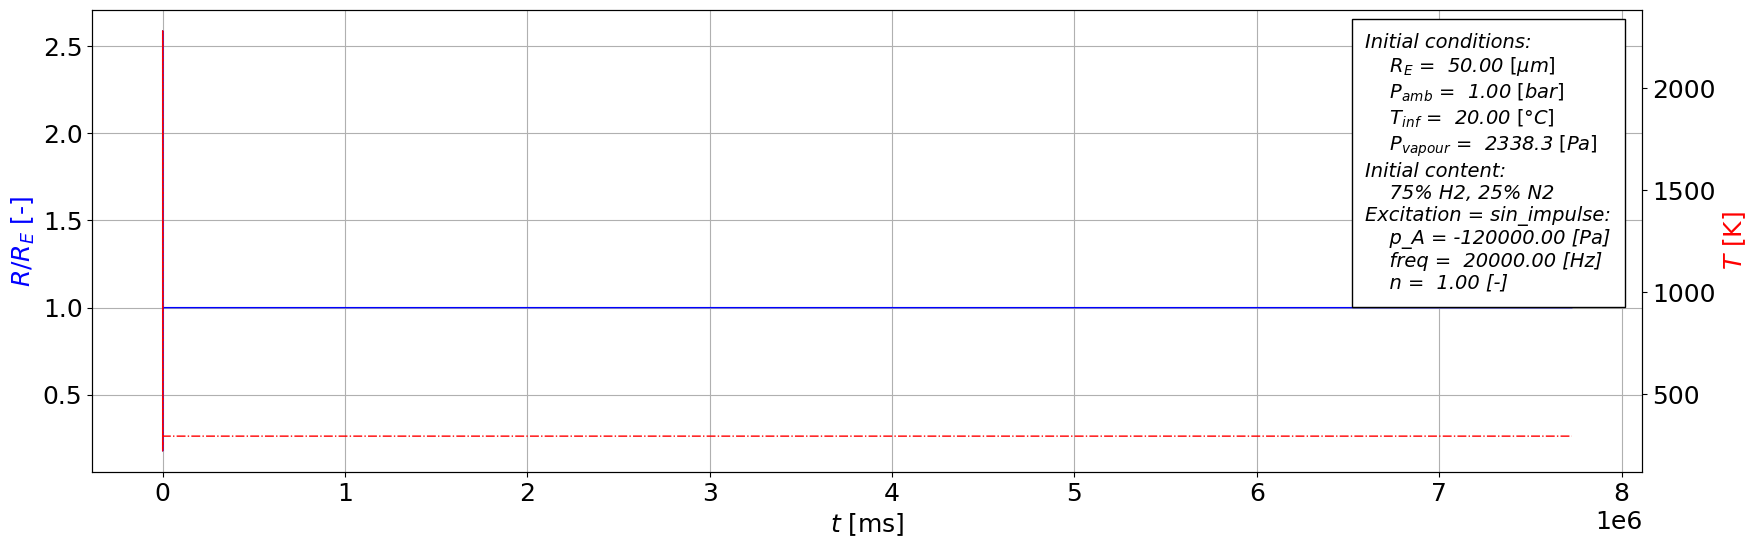

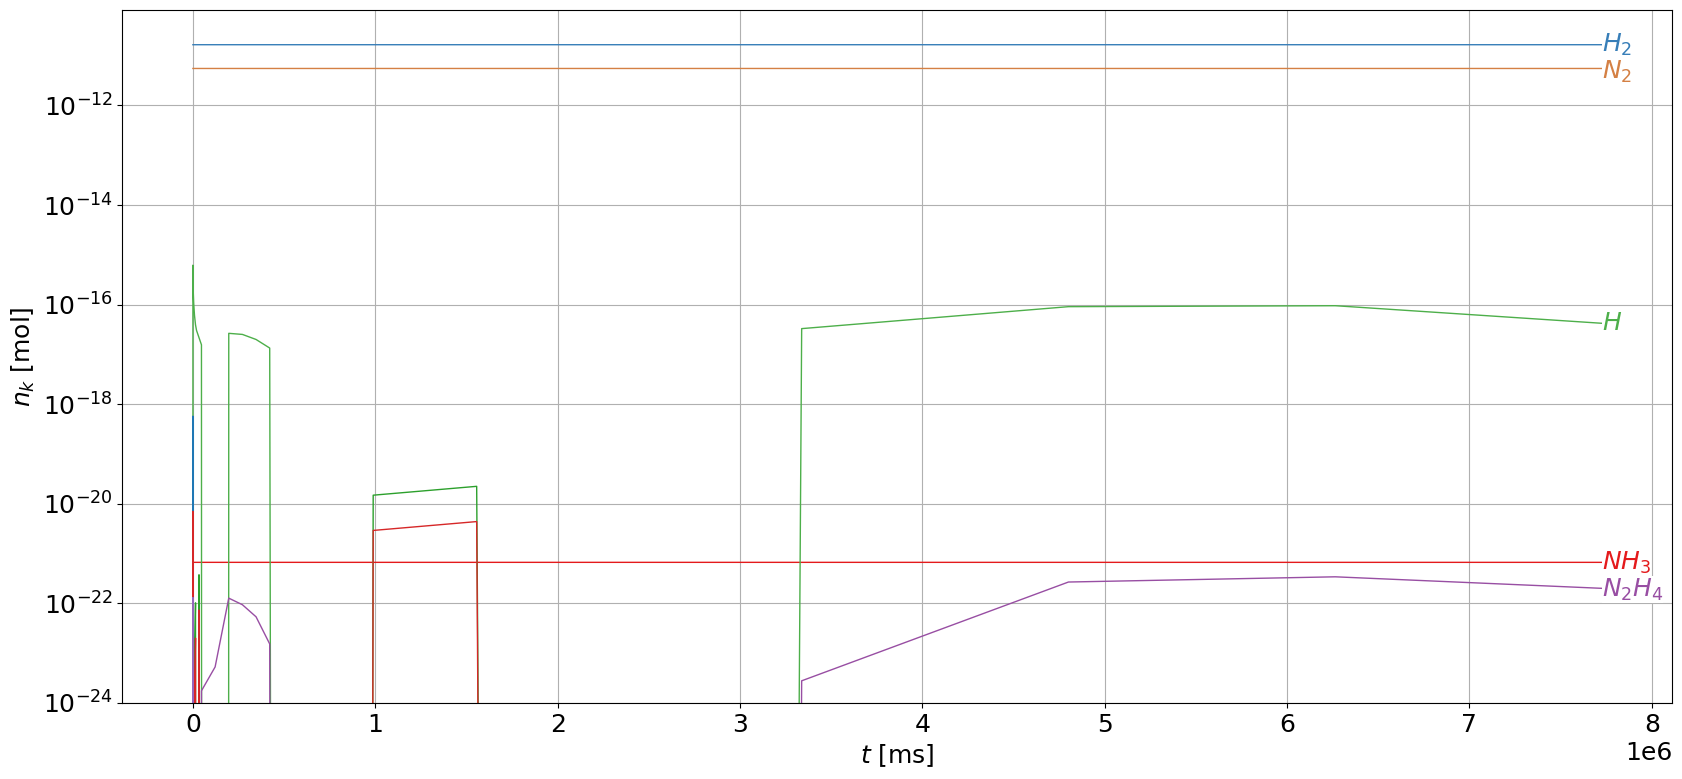

Control parameters:
    ID = 0,                                      # ID of control parameter (not used during calculation)
  # Initial conditions:
    R_E =  5.000000e-05,                         # bubble equilibrium radius [m]
    ratio =  1.00,                               # initial radius / equilibrium radius R_0/R_E [-]
    gases = [par.index['H2'], par.index['N2']],  # indexes of species in initial bubble (list of species indexes)
    fractions = [0.75, 0.25],                    # molar fractions of species in initial bubble (list of fractions for every gas)
  # Ambient parameters:
    P_amb =  100000.00,                          # ambient pressure [Pa]
    T_inf =  293.15,                             # ambient temperature [K]
  # Liquid parameters:
    alfa_M =  0.9900,                            # water accommodation coefficient [-]
    P_v =  2338.34,                              # vapour pressure [Pa]
    mu_L =  0.001000,                            # dynamic viscosity [Pa*

In [30]:
"""Plotting"""
import numpy as np
de.plot(cpar, t_int=np.array([0.0, 1.0e4]))

In [31]:
"""Saving"""
import numpy as np
file = de.Make_dir('test', separator=',')   # it makes a folder named 'test' in which it will save data
num_sol, error_code, elapsed_time = de.solve(cpar, t_int=np.array([0.0, 1.0e4]))   # simulation without plotting
data = de.get_data(cpar, num_sol, error_code, elapsed_time)   # post processing
file.write_solution(data, num_sol, 'testfile')   # saving (it overwrites data)
# If you would like to save data in an other format you should modify the list_to_string method in fubll_bubble_model.py, class Make_dir.
# If you would like to save data in other order you should modify the write_solution method. 


Folder already exists with 2 csv in it


In [ ]:
t_int=dict(t_int=np.array([0.0, 1.0e4])), 
n=5.0, 
base_name='', 
format='png', 
LSODA_timeout=30.0, 
Radau_timeout=300.0,
presentation_mode=False, 
plot_pressure=False, 
plot_extra=False, 
show_legend=False, 
show_cpar=True
if plot_extra:
    extra_dims = 4
else:
    extra_dims = 0
extra_dim_labels = ['Dissipated energy thermal term [J]', 'Dissipated energy viscous term [J]', 'Dissipated energy acoustic term [J]', 'Total dissipated energy [J]']
# Solve
if type(cpar) == dict:
    cpar = dotdict(cpar)
compression = 1 if base_name == '' else 0
num_sol, error_code, elapsed_time = de.solve(cpar, t_int, LSODA_timeout, Radau_timeout, extra_dims, print_errors=True, compression=compression)
data = de.get_data(cpar, num_sol, error_code, elapsed_time)